# **📄 Drug Design Project: Data Retrieval for BACE-1**
## 🎯 Learning and Training Objectives
### The primary objectives for this project notebook are:
Retrieving compound data and activities from the $\text{ChEMBL}$ database for the target protein $\text{BACE-1}$ (Beta-secretase 1).

Understanding and standardizing units of activity, primarily focusing on $\text{IC50}$ and its conversion to $\text{pIC50}$.
## 🧬 Target Protein: BACE-1 (Beta-secretase 1)
$\text{BACE-1}$ is a crucial enzyme (an aspartyl protease) that cleaves the Amyloid Precursor Protein ($\text{APP}$). This cleavage is the first step in the formation of $\beta$-amyloid peptides, which are a major component of the plaques found in the brains of patients with Alzheimer's disease. As such, $\text{BACE-1}$ is a significant therapeutic target for developing treatments for Alzheimer's .

### 📉 Understanding Bioactivity Units ($\text{IC50}$ and $\text{pIC50}$)
•	$\text{IC50}$ (Half maximal inhibitory concentration) is the standard unit used to measure the potency of an inhibitor1. Lower $\text{IC50}$ values indicate higher drug potency2.

•	$\text{pIC50}$ is the negative logarithm of the $\text{IC50}$ ($\text{pIC50} = -\log_{10}(\text{IC50})$)3. Higher $\text{pIC50}$ values indicate higher drug potency4.


## 💻 Pre-requisite Installation and Imports
This project requires the following Python libraries for data access and cheminformatics processing:


In [1]:
! pip install chembl_webresource_client
! pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 54.4 MB/s eta 0:00:00


In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
import os
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
from google.colab import drive

In [4]:
# Mount Google Drive
# This will prompt you to click a link, sign in, and paste an authorization code.
drive.mount('/content/drive')

# Define the base directory for your project in Google Drive
# DRIVE_DIR is the permanent location for your project files
DRIVE_DIR = Path("/content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data")

# Create the folder if it doesn't already exist
DRIVE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data saving path is: {DRIVE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saving path is: /content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data


### **🧬 Retrieving Data for BACE-1 from ChEMBL**
In this section, we set up the $\text{ChEMBL}$ API client and define our target of interest: $\text{BACE-1}$.
Creating some API tokens for target
#### Target Identification
We will use the $\text{Uniprot}$ Accession ID for Human $\text{BACE-1}$ to retrieve its data from $\text{ChEMBL}$.


In [5]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [6]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [7]:
#The Uniprot ID for Homo sapiens BACE-1 is P56817
uniprot_id = "P56817"

In [8]:
# Get BACE-1 target information from ChEMBL but restrict it to specified values only

targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [10]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Beta-secretase 1,CHEMBL4822,SINGLE PROTEIN
1,Homo sapiens,Beta-secretase 1,CHEMBL4822,SINGLE PROTEIN
2,Homo sapiens,Beta-secretase (BACE),CHEMBL2111390,PROTEIN FAMILY


The target of interest is the first on the table
Below we will select the exact ChEMBL data via index options

In [11]:
# Select the most relevant target, typically the SINGLE PROTEIN entry (index 0)
target = targets.iloc[0]
target

,0
organism,Homo sapiens
pref_name,Beta-secretase 1
target_chembl_id,CHEMBL4822
target_type,SINGLE PROTEIN


In [12]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL4822


The next step is to fetch important variables of the data for further analysis.
The variables selected can be modified to suit the purpose of the project.

In [13]:
# Fetch bioactivities (IC50) for the selected BACE-1 target ID.
# We are restricting to IC50 values with an exact relation and assay type 'B' (Binding/Functional).
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 12684, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in the bioactivity dataset holds the following information:

In [14]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 78857,
 'assay_chembl_id': 'CHEMBL653511',
 'assay_description': 'Inhibitory activity against Beta-secretase 1 was determined',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL406146',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '413.0',
 'target_chembl_id': 'CHEMBL4822',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '413.0'}

Download the dataset into a pandas dataframe

In [15]:
# Downloading Data and converting it into a Pandas DataFrame
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"The bioactivities DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

The bioactivities DataFrame shape: (12684, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50,nM,413.0
1,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50,uM,0.002
2,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50,uM,0.46
3,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50,uM,9.0
4,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50,uM,5.6


In [16]:
location = DRIVE_DIR / "raw_bioactivities_data.csv"
bioactivities_df.to_csv(location, index=False)

print(f"Raw bioactivity dataset saved to: {location}")

Raw bioactivity dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data/raw_bioactivities_data.csv


Note: It is possible that some of the rows show redundant data, prunning will be carried out soon.

**how many different units are present in the data?**

In [17]:
bioactivities_df["units"].unique()

array(['nM', 'uM', 'M', 'mM', 'umol/L', 'microM', "10'-7M", "10'-8M",
       'ug ml-1'], dtype=object)

Below we will do some tweaking with units to make them uniform

In [18]:
# Remove the redundant or intermediary 'units' and 'value' columns
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
1,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50
2,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50
3,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50
4,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50


### **Data Processing and Filteration: Prunning stage**

Delete entries with missing and duplicate values.

Reset index number and rename columns.



In [19]:
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,object
target_chembl_id,object
target_organism,object


In [20]:
# Ensure standard_value is treated as a numeric float for calculations
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,float64
target_chembl_id,object
target_organism,object


In [21]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (12684, 11)


Making sure the all the instances of the dataset has the same 'standard unit'

In [22]:
#Checking for the not nM instances
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1']
Number of non-nM entries:    2


In [23]:
# Filter the data to only include measurements in the standard unit: 'nM' (nanomolar)
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [24]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (12682, 11)


In [26]:
bioactivities_df1 = bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first")
print(f"DataFrame shape: {bioactivities_df1.shape}")

DataFrame shape: (8172, 11)


In [27]:
#Reset the ordering number since prunning has scattered it a bit
bioactivities_df1.reset_index(drop=True, inplace=True)
bioactivities_df1.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
1,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50
2,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50
3,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50
4,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50


In [28]:
# Rename the standard columns to be more informative for the project
bioactivities_df2 = bioactivities_df1.rename(
    columns={"standard_value": "IC50", "standard_units": "units"},
)
bioactivities_df2.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
1,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50
2,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50
3,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50
4,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50


In [29]:
print(f"DataFrame shape: {bioactivities_df2.shape}")

DataFrame shape: (8172, 11)


In [30]:
location_2 = DRIVE_DIR / "cleaned_bioactivities_data.csv"
bioactivities_df2.to_csv(location_2, index=False)

print(f"Preprocessed bioactivity dataset saved to: {location_2}")

Preprocessed bioactivity dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data/cleaned_bioactivities_data.csv


### **🏗️ Fetching Compound Structures and Merging**

We now fetch the chemical structures for the compounds linked to the filtered $\text{BACE-1}$ bioactivity data and merge the datasets.

Let’s have a look at the compounds from ChEMBL which we have defined bioactivity data for.
We are going to fetch compound ChEMBL IDs and structures for the compounds in the filtered bioactivity data.

In [31]:
# Fetch compound ChEMBL IDs and structures (canonical_smiles) for our filtered list
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df2["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [43]:
# Downloading Compounds with a progress bar
compounds = list(tqdm(compounds_provider))

  0%|          | 0/8172 [00:00<?, ?it/s]

In [44]:
# Convert the list of compound records into a DataFrame
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (8172, 2)


In [45]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
2,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...
3,CHEMBL76,{'canonical_smiles': 'CCN(CC)CCCC(C)Nc1ccnc2cc...
4,CHEMBL502,{'canonical_smiles': 'COc1cc2c(cc1OC)C(=O)C(CC...


In [46]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (8172, 2)


In [47]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [48]:
# Extract the canonical SMILES string from the nested molecule_structures dictionary
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (8172, 2)


In [49]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (8172, 2)


In [50]:
location_3 = DRIVE_DIR / "cleaned_compound_data.csv"
compounds_df.to_csv(location_3, index=False)

print(f"final compounds dataset saved to: {location_3}")

final compounds dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data/cleaned_compound_data.csv


**Let's output compound bioactivity and compound data**

In [51]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df2.columns

Bioactivities filtered: 8172


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [54]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 8172


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**Lets merge both the datasets**

Merge to contain, molecule ID, IC50, Units, and canonical smiles

In [55]:
# Merge DataFrames to contain molecule ID, IC50, Units, and canonical smiles
output_df = pd.merge(
    bioactivities_df2[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 8172 entries.


In [56]:
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [57]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL406146,413.0,nM,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...
1,CHEMBL78946,2.0,nM,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...
2,CHEMBL324109,460.0,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...
3,CHEMBL114147,9000.0,nM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...
4,CHEMBL419949,5600.0,nM,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...
5,CHEMBL116826,34000.0,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...
6,CHEMBL143239,20.0,nM,CC(C)[C@H](NC(=O)C[C@H](O)[C@H](Cc1cc(F)cc(F)c...
7,CHEMBL332948,21.0,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...
8,CHEMBL51386,300.0,nM,CSCC[C@H](NC(=O)[C@@H](NC(C)=O)C(C)C)C(=O)N[C@...
9,CHEMBL332260,50.0,nM,CC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1ccccc1)[C...


In [89]:
def norm_value(input):
  norm = []

  for i in input['IC50']:
    if i > 100000000:
      i = 100000000
    norm.append(i)

  input['IC50_norm'] = norm
  x = input.drop('IC50', axis=1)

  return x

In [90]:
outputnorm_df = norm_value(output_df)
outputnorm_df.head(5)

,molecule_chembl_id,units,smiles,IC50_norm
0,CHEMBL406146,nM,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0
1,CHEMBL78946,nM,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0
2,CHEMBL324109,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0
3,CHEMBL114147,nM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0
4,CHEMBL419949,nM,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0


In [91]:
outputnorm_df.IC50_norm.describe()

,IC50_norm
count,8.171000e+03
mean,9.300403e+04
std,2.742984e+06
min,2.000000e-04
25%,1.900000e+01
50%,1.410000e+02
75%,1.717000e+03
max,1.000000e+08


In [92]:
output_dfz = outputnorm_df.copy()
output_dfz.head()

,molecule_chembl_id,units,smiles,IC50_norm
0,CHEMBL406146,nM,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0
1,CHEMBL78946,nM,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0
2,CHEMBL324109,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0
3,CHEMBL114147,nM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0
4,CHEMBL419949,nM,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0


In [93]:
# Remove any molecule records that do not have a SMILES string.
# These records are useless for structure-based ML.
print(f"Output_df before dropping NaN SMILES: {output_dfz.shape}")
output_dfz.dropna(subset=['smiles'], inplace=True)
print(f"output_df after dropping NaN SMILES: {output_dfz.shape}")

Output_df before dropping NaN SMILES: (8171, 4)
output_df after dropping NaN SMILES: (8171, 4)


In [94]:
# Remove duplicates based on structure ['smiles']
output_df1 = output_dfz.drop_duplicates(subset="smiles", keep="first")
print(f"DataFrame shape: {output_df1.shape}")

DataFrame shape: (8171, 4)



## **📈 Calculating pIC50 and Final Data Preparation**
Convert IC50 values into pIC50 and put it in an extra column.

We convert the $\text{IC50}$ values to $\text{pIC50}$ for potency scoring, add the RDKit molecule object, and save the final dataset.


In [61]:
# Function to convert IC50 (nM) to pIC50
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [95]:
# Apply conversion to each row of the compounds DataFrame
output_df1["pIC50"] = output_df1.apply(lambda x: convert_ic50_to_pic50(x.IC50_norm), axis=1)

In [96]:
output_df1.head()

,molecule_chembl_id,units,smiles,IC50_norm,pIC50
0,CHEMBL406146,nM,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0,6.384050
1,CHEMBL78946,nM,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0,8.698970
2,CHEMBL324109,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0,6.337242
3,CHEMBL114147,nM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0,5.045757
4,CHEMBL419949,nM,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0,5.251812


Distribution Based on IpIC50

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

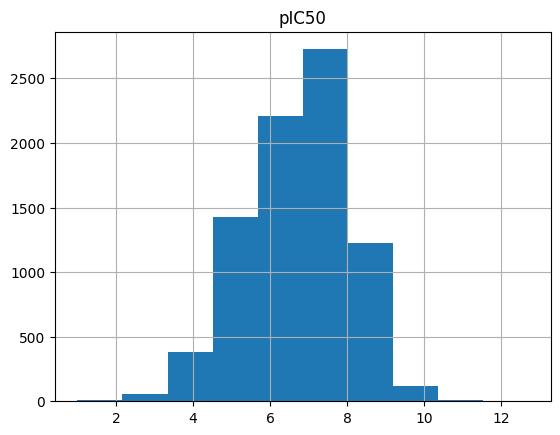

In [97]:
output_df1.hist(column="pIC50")

In [107]:
output_df2 = output_df1.copy()

In the next steps, we add a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [108]:
# Add RDKit molecule objects to the DataFrame for structural manipulation and visualization
PandasTools.AddMoleculeColumnToFrame(output_df2, smilesCol="smiles")

In [109]:
# Sort molecules by pIC50 to see the most potent BACE-1 inhibitors at the top
output_df2.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df2.reset_index(drop=True, inplace=True)

In [110]:
output_df2.drop("smiles", axis=1).head(3)

,molecule_chembl_id,units,IC50_norm,pIC50,ROMol
0,CHEMBL3969403,nM,0.0002,12.698970,<rdkit.Chem.rdchem.Mol object at 0x7c331072e490>
1,CHEMBL3937515,nM,0.0009,12.045757,<rdkit.Chem.rdchem.Mol object at 0x7c331072e500>
2,CHEMBL3949213,nM,0.0010,12.000000,<rdkit.Chem.rdchem.Mol object at 0x7c331072e5e0>


In [111]:
# Prepare saving the dataset: Drop the RDKit ROMol object as it cannot be saved to CSV
output_df2 = output_df2.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df2.shape}")

DataFrame shape: (8171, 5)


In [112]:
# Save the processed dataset of BACE-1 inhibitors
location4 = DRIVE_DIR / "BACE1_bioactivities_datalast2.csv"
output_df2.to_csv(location4, index=False)

print(f"Dataset saved to: {location4}")


Dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data/BACE1_bioactivities_datalast2.csv


In [113]:
output_df2.head()

,molecule_chembl_id,units,smiles,IC50_norm,pIC50
0,CHEMBL3969403,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,0.0002,12.698970
1,CHEMBL3937515,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,0.0009,12.045757
2,CHEMBL3949213,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,0.0010,12.000000
3,CHEMBL3955051,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,0.0018,11.744727
4,CHEMBL3936264,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,0.0057,11.244125


In [114]:
print(f"DataFrame shape: {output_df2.shape}")

DataFrame shape: (8171, 5)


In [85]:
output_df2.IC50.describe()

,IC50
count,8.171000e+03
mean,7.538778e+05
std,2.709270e+07
min,2.000000e-04
25%,1.900000e+01
50%,1.410000e+02
75%,1.717000e+03
max,1.000000e+09


## Classification for Machine Learning
To prepare our dataset for machine learning classification tasks (e.g., predicting if a compound is 'Active' or 'Inactive'), we will follow the methodology in Notebook B and categorize the continuous $\text{pIC}_{50}$ values into three discrete classes: Active, Intermediate, and Inactive.
This is essential for building a predictive classification model later in the project.

The standard cutoffs used in cheminformatics, based on the $\text{IC}_{50}$ value in nM, are translated to $\text{pIC}_{50}$ as follows:

$\text{pIC}_{50} \ge 6.0$ (equivalent to $\text{IC}_{50} \le 1000$ nM) $\rightarrow$ Active

$\text{pIC}_{50} \le 5.0$ (equivalent to $\text{IC}_{50} \ge 10000$ nM) $\rightarrow$ Inactive

$5.0 < \text{pIC}_{50} < 6.0$ $\rightarrow$ Intermediate

We will create a new column, bioactivity_class, to hold these labels.

In [115]:

# Define the classification function based on pIC50 thresholds
# This function uses the pIC50 cutoffs for BACE-1 data.
def classify_bioactivity(pic50):
    """
    Classifies a compound's bioactivity based on the pIC50 value.
    pIC50 >= 6.0 (IC50 <= 1000 nM) is Active.
    pIC50 <= 5.0 (IC50 >= 10000 nM) is Inactive.
    """
    if pic50 >= 6.0:
        return "Active"
    elif pic50 <= 5.0:
        return "Inactive"
    else:
        # Compounds between 1000 nM and 10000 nM
        return "Intermediate"


In [116]:
# The DataFrame is named 'output_df2' and contains the 'pIC50' column from previous steps.
# Apply the classification function to create the new column
output_df2['bioactivity_class'] = output_df2['pIC50'].apply(classify_bioactivity)

In [117]:
# Display the distribution and the modified DataFrame
print("Distribution of Bioactivity Classes:")
print(output_df2['bioactivity_class'].value_counts())

Distribution of Bioactivity Classes:
bioactivity_class
Active          5699
Intermediate    1592
Inactive         880
Name: count, dtype: int64


In [118]:
# Display the first few rows with the new column
output_df2.head()

,molecule_chembl_id,units,smiles,IC50_norm,pIC50,bioactivity_class
0,CHEMBL3969403,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,0.0002,12.698970,Active
1,CHEMBL3937515,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,0.0009,12.045757,Active
2,CHEMBL3949213,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,0.0010,12.000000,Active
3,CHEMBL3955051,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,0.0018,11.744727,Active
4,CHEMBL3936264,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,0.0057,11.244125,Active


**Save Dataset for Next Session**

In [119]:
location5 = DRIVE_DIR / "BACE1_Modeling_data.csv"
output_df2.to_csv(location5, index=False)

print(f"Final dataset saved to: {location5}")


Final dataset saved to: /content/drive/My Drive/Data Science and ML courses/CADD/Raw_Data/BACE1_Modeling_data.csv
